In [1]:
!nvidia-smi

Fri Jan  6 16:29:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:AF:00.0 Off |                  N/A |
| 37%   76C    P3    52W / 215W |    232MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup imports

In [2]:
import logging
import os
import sys
import time

import pandas as pd
import numpy as np
import random
import torch
from torchmetrics.classification import BinaryF1Score
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

from matplotlib import pylab as plt

import monai
from monai.data import (
    decollate_batch,
    list_data_collate,
    ITKReader,
    NumpyReader,
)
from monai.inferers import SimpleInferer
from monai.networks.nets import DenseNet121
from monai.metrics import ROCAUCMetric
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    Flipd,
    Lambdad,
    LoadImaged,
    RandAdjustContrastd, #check whether necessary
    RandFlipd,
    RandAffined,
    Resize,
    Resized,
    Rotate90d,
    ScaleIntensity,
    ScaleIntensityd,
    ToTensor,
    ToTensord,
    ToNumpy,
    ToNumpyd,
)
from monai.utils import first, set_determinism

# Setup data directory


In [3]:

pn_code = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\PYTHON'
pn_data = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\data\\data_dv3d_monai_QA'

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

df = pd.read_csv(os.path.join(pn_code,'df_dv3d_oc_monai_files.csv'), index_col=0)

# set up dataset splits and dict-lists
nr_train_samples = 5000
train_idxs = np.arange(nr_train_samples)
valid_idxs = np.arange(nr_train_samples,df.shape[0])

train_files = [{"img": os.path.join(pn_data, fn_img), "seg": os.path.join(pn_data, fn_seg)} for fn_img, fn_seg in zip(df.fn_img[train_idxs], df.fn_cls[train_idxs])]
val_files = [{"img": os.path.join(pn_data, fn_img), "seg": os.path.join(pn_data, fn_seg)} for fn_img, fn_seg in zip(df.fn_img[valid_idxs], df.fn_cls[valid_idxs])]

print(f'df.columns:\n {df.columns.tolist()}')
df.head()

MONAI version: 1.0.1
Numpy version: 1.22.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: E:\Users\BerkOlcay\anaconda3\envs\DL\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.4.1
transformers version: 4.24.0
mlflow version: 1.30.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

df.columns:
 ['fn_img', 'fn_cls']


,fn_img,fn_cls
0,12451_ubiris2_C107_S1_I7_000000.tiff,pickle_open_close\12451_ubiris2_C107_S1_I7_000...
1,12452_ubiris2_C133_S1_I4_000000.tiff,pickle_open_close\12452_ubiris2_C133_S1_I4_000...
2,12453_ubiris2_C79_S2_I2_000000.tiff,pickle_open_close\12453_ubiris2_C79_S2_I2_0000...
3,12454_ubiris2_C390_S1_I15_000000.tiff,pickle_open_close\12454_ubiris2_C390_S1_I15_00...
4,12455_ubiris2_C85_S1_I1_000000.tiff,pickle_open_close\12455_ubiris2_C85_S1_I1_0000...


# Set deterministic for reproducibility

In [4]:
set_determinism(seed=0)

# Downsample due to unbalanced dataset

In [5]:
all_files = train_files + val_files 
print("len(train_files)",len(train_files))
print("len(val_files)",len(val_files))
print("len(all_files)",len(all_files))

open_eye_idxs = np.array([])
close_eye_idxs = np.array([])

for index, item in enumerate(all_files):
    nploader = monai.transforms.LoadImage(reader= "NumpyReader")
    lbl = np.array(nploader(all_files[index]['seg'])[0])
    if (lbl == 0):
        close_eye_idxs = np.append(close_eye_idxs, index)
    else:
        open_eye_idxs = np.append(open_eye_idxs, index)
        
print("len(open_eye_idxs)",len(open_eye_idxs))
print("len(close_eye_idxs))",len(close_eye_idxs))

random_open_eye_idxs = np.sort(random.sample(range(len(open_eye_idxs)), len(close_eye_idxs)))
random_open_eye_idxs = np.array(open_eye_idxs[random_open_eye_idxs])
print("len(random_open_eye_idxs)", len(random_open_eye_idxs))
shuffled_close_eye_idxs = np.copy(close_eye_idxs)
print("len(shuffled_close_eye_idxs)", len(shuffled_close_eye_idxs))

test_frac = int(len(random_open_eye_idxs)/10)
val_frac = test_frac*2
print("test_frac", test_frac)
print("val_frac", val_frac)

test_idxs = np.concatenate([random_open_eye_idxs[:test_frac], shuffled_close_eye_idxs[:test_frac]])
val_idxs = np.concatenate([random_open_eye_idxs[test_frac:val_frac], shuffled_close_eye_idxs[test_frac:val_frac]])
train_idxs = np.concatenate([random_open_eye_idxs[val_frac:], shuffled_close_eye_idxs[val_frac:]])
print("len(train_idxs)", len(train_idxs))
print("len(val_idxs)", len(val_idxs))
print("len(test_idxs)", len(test_idxs))

len(train_files) 5000
len(val_files) 506
len(all_files) 5506
len(open_eye_idxs) 5322
len(close_eye_idxs)) 184
len(random_open_eye_idxs) 184
len(shuffled_close_eye_idxs) 184
test_frac 18
val_frac 36
len(train_idxs) 296
len(val_idxs) 36
len(test_idxs) 36


In [6]:
undersampled_train_files = []
undersampled_val_files = []
undersampled_test_files = []
for index, item in enumerate(all_files):
    if index in train_idxs:
        undersampled_train_files.append(item)
    elif index in val_idxs:
        undersampled_val_files.append(item)
    elif index in test_idxs:
        undersampled_test_files.append(item)
print(len(undersampled_train_files))
print(len(undersampled_val_files))
print(len(undersampled_test_files))

296
36
36


# Setup transforms for training and validation


In [7]:
# define transforms for image and segmentation
img_size = np.array([240,320])
rot_max = 45*np.pi/180.0
shear_max = 0.5
trans_max = tuple((img_size*0.15).astype(int))

def gray2rgb(x):
    #print(x.shape)
    if x.shape[0]==1:
        x = x.repeat(3, 1, 1)
        x.meta['original_channel_dim'] = -1 # THIS is the important line! 
    #print(x.shape)
    return x

def clean_tiff_meta(x):
    for key in ['DocumentName', 'ImageDescription', 'Software']:
        if key in x.meta.keys():
            del x.meta[key]
    return x

train_transforms = Compose(
    [
        LoadImaged(keys=["img"], reader= ITKReader, image_only = True),
        LoadImaged(keys=["seg"], reader=NumpyReader, image_only = True),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=['img'], func=lambda x: gray2rgb(x)), # gray to rgb conversion
        ScaleIntensityd(keys="img"),        
        Resized(keys=["img"], spatial_size=(240,320)),
        RandFlipd(keys=["img"], prob=0.5, spatial_axis=[0,1]),
        RandAffined(keys=["img"], prob=0.5,
                    rotate_range=rot_max, 
                    shear_range=shear_max, 
                    translate_range=trans_max, 
                    padding_mode='zeros'),
        EnsureTyped(keys="img"),
        Lambdad(keys=['img'], func=lambda x: clean_tiff_meta(x)), # clean weird keys in TIFF metadata
        ToTensord(keys=["img", "seg"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["img"], reader= ITKReader, image_only = True),
        LoadImaged(keys=["seg"], reader=NumpyReader, image_only = True),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=['img'], func=lambda x: gray2rgb(x)), # gray to rgb conversion
        ScaleIntensityd(keys="img"),
        Resized(keys=["img"], spatial_size=(240,320)),
        EnsureTyped(keys="img"),
        Lambdad(keys=['img'], func=lambda x: clean_tiff_meta(x)), # clean weird keys in TIFF metadata
        ToTensord(keys=["img", "seg"]),
    ]
)

# Data Check

In [8]:
def draw_image(frame_rgb, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()

In [ ]:
print(len(train_files), "train files")

file_types= []
indexes = []
for index, item in enumerate(train_files):
    extension = os.path.splitext(item['img'])[1]
    if (extension not in file_types):
        file_types.append(extension)
        indexes.append(index)
    if (item['seg'] == 1.0):
        openEyeCounter = openEyeCounter + 1

print("available formats ", file_types)
print(indexes)

for i in indexes:
    print(train_files[i]['img'])
    
flag_text_loader_check = True
if flag_text_loader_check:
    fig, axs = plt.subplots(1,4)
    loader = monai.transforms.LoadImage(reader= "ITKReader")
    nploader = monai.transforms.LoadImage(reader= "NumpyReader")
    for i, index in enumerate(indexes):
        img = loader(train_files[index]['img'])
        arr=np.array(img[0])
        print(file_types[i], "image shape", arr.shape)
        lbl = np.array(nploader(train_files[index]['seg'])[0])
        print(file_types[i], "label shape", lbl.shape)
        axs[i].imshow(arr/255)
        axs[i].set_xlabel(file_types[i])
    plt.show()

In [10]:
'''
npc = ToNumpy()

check_batch_size = len(train_files)
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(
    check_ds, 
    batch_size=check_batch_size, 
    shuffle=False,
    num_workers=0)
check_data = first(check_loader)
openEyeCounter = np.sum(check_data["seg"])
print("%", openEyeCounter/check_batch_size, openEyeCounter, "open eye out of", check_batch_size, "train data")

check_batch_size = len(val_files)
check_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(
    check_ds, 
    batch_size=check_batch_size, 
    shuffle=False,
    num_workers=0)
check_data = first(check_loader)
openEyeCounter = np.sum(check_data["seg"])
print("%", openEyeCounter/check_batch_size, openEyeCounter, "open eye out of", check_batch_size, "validation data")
'''
# % 0.9674 4837.0 open eye out of 5000 train data
# % 0.958498023715415 485.0 open eye out of 506 validation data

'\nnpc = ToNumpy()\n\ncheck_batch_size = len(train_files)\ncheck_ds = monai.data.Dataset(data=train_files, transform=train_transforms)\ncheck_loader = DataLoader(\n    check_ds, \n    batch_size=check_batch_size, \n    shuffle=False,\n    num_workers=0)\ncheck_data = first(check_loader)\nopenEyeCounter = np.sum(check_data["seg"])\nprint("%", openEyeCounter/check_batch_size, openEyeCounter, "open eye out of", check_batch_size, "train data")\n\ncheck_batch_size = len(val_files)\ncheck_ds = monai.data.Dataset(data=val_files, transform=val_transforms)\ncheck_loader = DataLoader(\n    check_ds, \n    batch_size=check_batch_size, \n    shuffle=False,\n    num_workers=0)\ncheck_data = first(check_loader)\nopenEyeCounter = np.sum(check_data["seg"])\nprint("%", openEyeCounter/check_batch_size, openEyeCounter, "open eye out of", check_batch_size, "validation data")\n'

In [ ]:
# check loaded images and augmentations
# define check dataset, check data loader
npc = ToNumpy()
check_batch_size = 20
check_ds = monai.data.Dataset(data=train_files[1000:], transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=check_batch_size, shuffle=True, num_workers=0)
check_data = first(check_loader) #check_data = monai.utils.misc.first(check_loader)
for i in range(check_batch_size):
    # channel first versions
    img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
    seg_cf = np.squeeze(npc(check_data["seg"])[i])
    # channel last versions for plotting
    img = np.moveaxis(img_cf, [0,1,2], [-1,-3,-2])
    draw_image(img)
    classification = 'open' if seg_cf == 1 else 'close'
    print(classification)
    

# check filenames in minibatch
# check_data['img_meta_dict']['format']

# Create cached data loaders for training and validation

In [13]:
train_ds = monai.data.CacheDataset(data=undersampled_train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

val_ds = monai.data.CacheDataset(data=undersampled_val_files, transform=val_transforms)
val_loader = DataLoader(
    val_ds, 
    batch_size=32, 
    num_workers=0, 
    collate_fn=list_data_collate
)

test_ds = monai.data.CacheDataset(data=undersampled_test_files, transform=val_transforms)
test_loader = DataLoader(
    test_ds, 
    batch_size=32, 
    num_workers=0, 
    collate_fn=list_data_collate
)

y_pred_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
y_trans = Compose([AsDiscrete()])

Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 53.39it/s]


# Create Model, Loss, Optimizer

In [14]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = DenseNet121(spatial_dims=2, 
                    in_channels=3,
                    out_channels=1).to(device)

#weights = [0.9674, 0.0326]
#weights = torch.tensor([29.67], dtype=torch.float32, device=device)
#class_weights = torch.FloatTensor(weights).cuda()
#loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
#loss_function = torch.nn.CrossEntropyLoss()
#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

max_epochs = 3000
val_interval = 1

auc_metric = ROCAUCMetric()
f1_metric = BinaryF1Score().to(device)

device: cuda


In [15]:
print(model)

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

# Training process

In [16]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
f1_metric_values = []

sig_act = torch.nn.Sigmoid()
soft_act = torch.nn.Softmax()

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    tmpindex = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs)
        #print(labels)
        tmpindex = tmpindex + 1
#        if (tmpindex == 1):
#            print(outputs)
#            print(soft_act(outputs))
#            print(labels)
#            print ("loss wo activation", loss_function(outputs, labels))
#            print ("loss with activation", loss_function(soft_act(outputs), labels))
        #loss = loss_function(soft_act(outputs), labels)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#        print(f"{step}/{len(train_ds) // train_loader.batch_size}, "f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["img"].to(device),
                    val_data["seg"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            #print(y)
            #print(y_pred)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            #print("y_onehot",y_onehot)
            #print("y_pred_act",y_pred_act)
            auc_metric(y_pred_act, y)
            result = auc_metric.aggregate()
            auc_metric.reset()
            f1_result = f1_metric(sig_act(y_pred).round(), y)
            #f1_result = f1_metric(y_pred, y)
            f1_result = np.squeeze(f1_result.cpu().numpy())
            f1_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            f1_metric_values.append(f1_result)
            acc_value = torch.eq(sig_act(y_pred).round(), y)
            #acc_value = torch.eq(y_pred.round(), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),"best_metric_model_oc_densenet121.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f} current f1: {f1_result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

total_time = time.time() - total_start

----------
epoch 1/3000
epoch 1 average loss: 0.6744
saved new best metric model
current epoch: 1 current AUC: 0.5000 current f1: 0.0000 current accuracy: 0.5000 best AUC: 0.5000 at epoch: 1
time consuming of epoch 1 is: 11.1871
----------
epoch 2/3000
epoch 2 average loss: 0.6393
current epoch: 2 current AUC: 0.5000 current f1: 0.0000 current accuracy: 0.5000 best AUC: 0.5000 at epoch: 1
time consuming of epoch 2 is: 6.0838
----------
epoch 3/3000
epoch 3 average loss: 0.6243
current epoch: 3 current AUC: 0.5000 current f1: 0.0000 current accuracy: 0.5000 best AUC: 0.5000 at epoch: 1
time consuming of epoch 3 is: 5.8439
----------
epoch 4/3000
epoch 4 average loss: 0.5952
current epoch: 4 current AUC: 0.5000 current f1: 0.1000 current accuracy: 0.5000 best AUC: 0.5000 at epoch: 1
time consuming of epoch 4 is: 6.0153
----------
epoch 5/3000
epoch 5 average loss: 0.5900
saved new best metric model
current epoch: 5 current AUC: 0.5556 current f1: 0.3333 current accuracy: 0.5556 best AUC:

----------
epoch 40/3000
epoch 40 average loss: 0.1908
current epoch: 40 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9167 at epoch: 34
time consuming of epoch 40 is: 6.0781
----------
epoch 41/3000
epoch 41 average loss: 0.1905
saved new best metric model
current epoch: 41 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9444 at epoch: 41
time consuming of epoch 41 is: 6.1406
----------
epoch 42/3000
epoch 42 average loss: 0.1779
current epoch: 42 current AUC: 0.9167 current f1: 0.9231 current accuracy: 0.9167 best AUC: 0.9444 at epoch: 41
time consuming of epoch 42 is: 6.0781
----------
epoch 43/3000
epoch 43 average loss: 0.1717
current epoch: 43 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9444 at epoch: 41
time consuming of epoch 43 is: 6.0156
----------
epoch 44/3000
epoch 44 average loss: 0.1705
current epoch: 44 current AUC: 0.9167 current f1: 0.9231 current accuracy: 0.9167 best AUC: 0.944

time consuming of epoch 79 is: 6.1094
----------
epoch 80/3000
epoch 80 average loss: 0.0917
current epoch: 80 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 80 is: 5.9844
----------
epoch 81/3000
epoch 81 average loss: 0.1459
current epoch: 81 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 81 is: 6.1250
----------
epoch 82/3000
epoch 82 average loss: 0.1397
current epoch: 82 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 82 is: 5.9219
----------
epoch 83/3000
epoch 83 average loss: 0.0952
current epoch: 83 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 83 is: 5.9219
----------
epoch 84/3000
epoch 84 average loss: 0.0865
current epoch: 84 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best 

epoch 120 average loss: 0.0846
current epoch: 120 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 120 is: 5.9843
----------
epoch 121/3000
epoch 121 average loss: 0.0820
current epoch: 121 current AUC: 0.9167 current f1: 0.9143 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 121 is: 5.9063
----------
epoch 122/3000
epoch 122 average loss: 0.0559
current epoch: 122 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 122 is: 6.0469
----------
epoch 123/3000
epoch 123 average loss: 0.0586
current epoch: 123 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 123 is: 5.9219
----------
epoch 124/3000
epoch 124 average loss: 0.0672
current epoch: 124 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 160 average loss: 0.0456
current epoch: 160 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 160 is: 6.5154
----------
epoch 161/3000
epoch 161 average loss: 0.0859
current epoch: 161 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 161 is: 6.5628
----------
epoch 162/3000
epoch 162 average loss: 0.0731
current epoch: 162 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 162 is: 6.3436
----------
epoch 163/3000
epoch 163 average loss: 0.0797
current epoch: 163 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 163 is: 6.1405
----------
epoch 164/3000
epoch 164 average loss: 0.0551
current epoch: 164 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 200 average loss: 0.0511
current epoch: 200 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 200 is: 6.1401
----------
epoch 201/3000
epoch 201 average loss: 0.0374
current epoch: 201 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 201 is: 6.1410
----------
epoch 202/3000
epoch 202 average loss: 0.0303
current epoch: 202 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 202 is: 6.1248
----------
epoch 203/3000
epoch 203 average loss: 0.0523
current epoch: 203 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 203 is: 6.0784
----------
epoch 204/3000
epoch 204 average loss: 0.0377
current epoch: 204 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 240 average loss: 0.0620
current epoch: 240 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 240 is: 6.0983
----------
epoch 241/3000
epoch 241 average loss: 0.0444
current epoch: 241 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 241 is: 6.0159
----------
epoch 242/3000
epoch 242 average loss: 0.0358
current epoch: 242 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 242 is: 6.0937
----------
epoch 243/3000
epoch 243 average loss: 0.1583
current epoch: 243 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 243 is: 6.0469
----------
epoch 244/3000
epoch 244 average loss: 0.0291
current epoch: 244 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 280 average loss: 0.0421
current epoch: 280 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 280 is: 5.9844
----------
epoch 281/3000
epoch 281 average loss: 0.0576
current epoch: 281 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 281 is: 5.9090
----------
epoch 282/3000
epoch 282 average loss: 0.0238
current epoch: 282 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 282 is: 6.1341
----------
epoch 283/3000
epoch 283 average loss: 0.0243
current epoch: 283 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 283 is: 6.1250
----------
epoch 284/3000
epoch 284 average loss: 0.0300
current epoch: 284 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 320 average loss: 0.0270
current epoch: 320 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 320 is: 6.1719
----------
epoch 321/3000
epoch 321 average loss: 0.0797
current epoch: 321 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 321 is: 6.1250
----------
epoch 322/3000
epoch 322 average loss: 0.0464
current epoch: 322 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 322 is: 6.2656
----------
epoch 323/3000
epoch 323 average loss: 0.0489
current epoch: 323 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 323 is: 6.0284
----------
epoch 324/3000
epoch 324 average loss: 0.0690
current epoch: 324 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 360 average loss: 0.0107
current epoch: 360 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 360 is: 6.1875
----------
epoch 361/3000
epoch 361 average loss: 0.0321
current epoch: 361 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 361 is: 6.0093
----------
epoch 362/3000
epoch 362 average loss: 0.0193
current epoch: 362 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 362 is: 6.0781
----------
epoch 363/3000
epoch 363 average loss: 0.0325
current epoch: 363 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 363 is: 5.8906
----------
epoch 364/3000
epoch 364 average loss: 0.0411
current epoch: 364 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 400 average loss: 0.0295
current epoch: 400 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 400 is: 6.1875
----------
epoch 401/3000
epoch 401 average loss: 0.0188
current epoch: 401 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 401 is: 6.0312
----------
epoch 402/3000
epoch 402 average loss: 0.0375
current epoch: 402 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 402 is: 6.1875
----------
epoch 403/3000
epoch 403 average loss: 0.0233
current epoch: 403 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 403 is: 6.1563
----------
epoch 404/3000
epoch 404 average loss: 0.0397
current epoch: 404 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 440 average loss: 0.0613
current epoch: 440 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 440 is: 6.1719
----------
epoch 441/3000
epoch 441 average loss: 0.0329
current epoch: 441 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 441 is: 6.0938
----------
epoch 442/3000
epoch 442 average loss: 0.0199
current epoch: 442 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 442 is: 6.1406
----------
epoch 443/3000
epoch 443 average loss: 0.0137
current epoch: 443 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 443 is: 5.9844
----------
epoch 444/3000
epoch 444 average loss: 0.0151
current epoch: 444 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 480 average loss: 0.0091
current epoch: 480 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 480 is: 6.0000
----------
epoch 481/3000
epoch 481 average loss: 0.0819
current epoch: 481 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 481 is: 6.1250
----------
epoch 482/3000
epoch 482 average loss: 0.0237
current epoch: 482 current AUC: 0.8889 current f1: 0.8824 current accuracy: 0.8889 best AUC: 0.9722 at epoch: 46
time consuming of epoch 482 is: 6.0781
----------
epoch 483/3000
epoch 483 average loss: 0.0310
current epoch: 483 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 483 is: 5.9687
----------
epoch 484/3000
epoch 484 average loss: 0.0199
current epoch: 484 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 520 average loss: 0.0141
current epoch: 520 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 520 is: 6.1563
----------
epoch 521/3000
epoch 521 average loss: 0.0079
current epoch: 521 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 521 is: 6.1250
----------
epoch 522/3000
epoch 522 average loss: 0.0105
current epoch: 522 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 522 is: 5.8906
----------
epoch 523/3000
epoch 523 average loss: 0.0771
current epoch: 523 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 523 is: 6.0781
----------
epoch 524/3000
epoch 524 average loss: 0.0144
current epoch: 524 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 560 average loss: 0.0114
current epoch: 560 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 560 is: 6.2656
----------
epoch 561/3000
epoch 561 average loss: 0.0072
current epoch: 561 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 561 is: 6.0625
----------
epoch 562/3000
epoch 562 average loss: 0.0081
current epoch: 562 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 562 is: 6.1094
----------
epoch 563/3000
epoch 563 average loss: 0.0232
current epoch: 563 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 563 is: 6.1719
----------
epoch 564/3000
epoch 564 average loss: 0.0841
current epoch: 564 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 600 average loss: 0.0073
current epoch: 600 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 600 is: 6.0156
----------
epoch 601/3000
epoch 601 average loss: 0.0112
current epoch: 601 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 601 is: 6.2656
----------
epoch 602/3000
epoch 602 average loss: 0.0318
current epoch: 602 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 602 is: 5.9844
----------
epoch 603/3000
epoch 603 average loss: 0.0271
current epoch: 603 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 603 is: 6.2031
----------
epoch 604/3000
epoch 604 average loss: 0.0072
current epoch: 604 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 640 average loss: 0.0064
current epoch: 640 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 640 is: 6.0625
----------
epoch 641/3000
epoch 641 average loss: 0.0087
current epoch: 641 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 641 is: 6.1094
----------
epoch 642/3000
epoch 642 average loss: 0.0094
current epoch: 642 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 642 is: 5.9219
----------
epoch 643/3000
epoch 643 average loss: 0.0106
current epoch: 643 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 643 is: 6.0000
----------
epoch 644/3000
epoch 644 average loss: 0.0117
current epoch: 644 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 680 average loss: 0.0103
current epoch: 680 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 680 is: 6.1307
----------
epoch 681/3000
epoch 681 average loss: 0.0138
current epoch: 681 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 681 is: 6.1562
----------
epoch 682/3000
epoch 682 average loss: 0.0200
current epoch: 682 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 682 is: 6.0469
----------
epoch 683/3000
epoch 683 average loss: 0.0163
current epoch: 683 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 683 is: 6.0617
----------
epoch 684/3000
epoch 684 average loss: 0.0058
current epoch: 684 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 720 average loss: 0.0140
current epoch: 720 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 720 is: 6.2344
----------
epoch 721/3000
epoch 721 average loss: 0.0167
current epoch: 721 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 721 is: 6.2969
----------
epoch 722/3000
epoch 722 average loss: 0.0641
current epoch: 722 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 722 is: 6.1094
----------
epoch 723/3000
epoch 723 average loss: 0.0140
current epoch: 723 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 723 is: 5.9531
----------
epoch 724/3000
epoch 724 average loss: 0.0227
current epoch: 724 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 760 average loss: 0.0084
current epoch: 760 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 760 is: 6.0157
----------
epoch 761/3000
epoch 761 average loss: 0.0145
current epoch: 761 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 761 is: 6.2031
----------
epoch 762/3000
epoch 762 average loss: 0.0062
current epoch: 762 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 762 is: 5.9687
----------
epoch 763/3000
epoch 763 average loss: 0.0063
current epoch: 763 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 763 is: 6.0156
----------
epoch 764/3000
epoch 764 average loss: 0.0086
current epoch: 764 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 800 average loss: 0.0055
current epoch: 800 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 800 is: 6.0000
----------
epoch 801/3000
epoch 801 average loss: 0.0082
current epoch: 801 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 801 is: 6.1406
----------
epoch 802/3000
epoch 802 average loss: 0.0092
current epoch: 802 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 802 is: 6.1250
----------
epoch 803/3000
epoch 803 average loss: 0.0058
current epoch: 803 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 803 is: 5.9219
----------
epoch 804/3000
epoch 804 average loss: 0.0180
current epoch: 804 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 840 average loss: 0.0188
current epoch: 840 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 840 is: 6.1250
----------
epoch 841/3000
epoch 841 average loss: 0.0110
current epoch: 841 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 841 is: 6.2344
----------
epoch 842/3000
epoch 842 average loss: 0.0085
current epoch: 842 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 842 is: 6.0781
----------
epoch 843/3000
epoch 843 average loss: 0.0058
current epoch: 843 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 843 is: 5.7813
----------
epoch 844/3000
epoch 844 average loss: 0.0078
current epoch: 844 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 880 average loss: 0.0060
current epoch: 880 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 880 is: 5.9219
----------
epoch 881/3000
epoch 881 average loss: 0.0132
current epoch: 881 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 881 is: 6.0781
----------
epoch 882/3000
epoch 882 average loss: 0.0044
current epoch: 882 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 882 is: 5.9734
----------
epoch 883/3000
epoch 883 average loss: 0.0076
current epoch: 883 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 883 is: 6.0312
----------
epoch 884/3000
epoch 884 average loss: 0.0207
current epoch: 884 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 920 average loss: 0.0031
current epoch: 920 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 920 is: 6.0156
----------
epoch 921/3000
epoch 921 average loss: 0.0051
current epoch: 921 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 921 is: 5.9375
----------
epoch 922/3000
epoch 922 average loss: 0.0029
current epoch: 922 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 922 is: 5.9219
----------
epoch 923/3000
epoch 923 average loss: 0.0118
current epoch: 923 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 923 is: 6.1406
----------
epoch 924/3000
epoch 924 average loss: 0.0076
current epoch: 924 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 960 average loss: 0.0054
current epoch: 960 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 960 is: 6.1250
----------
epoch 961/3000
epoch 961 average loss: 0.0847
current epoch: 961 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 961 is: 6.0469
----------
epoch 962/3000
epoch 962 average loss: 0.0048
current epoch: 962 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 962 is: 6.1563
----------
epoch 963/3000
epoch 963 average loss: 0.0052
current epoch: 963 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 963 is: 6.3125
----------
epoch 964/3000
epoch 964 average loss: 0.0272
current epoch: 964 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of ep

epoch 1000 average loss: 0.0155
current epoch: 1000 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1000 is: 6.0313
----------
epoch 1001/3000
epoch 1001 average loss: 0.0109
current epoch: 1001 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1001 is: 6.1094
----------
epoch 1002/3000
epoch 1002 average loss: 0.0609
current epoch: 1002 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1002 is: 6.0625
----------
epoch 1003/3000
epoch 1003 average loss: 0.0296
current epoch: 1003 current AUC: 0.9167 current f1: 0.9231 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1003 is: 5.9687
----------
epoch 1004/3000
epoch 1004 average loss: 0.0309
current epoch: 1004 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
ti

epoch 1039 average loss: 0.0047
current epoch: 1039 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1039 is: 6.1719
----------
epoch 1040/3000
epoch 1040 average loss: 0.0033
current epoch: 1040 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1040 is: 6.0156
----------
epoch 1041/3000
epoch 1041 average loss: 0.0082
current epoch: 1041 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1041 is: 5.9532
----------
epoch 1042/3000
epoch 1042 average loss: 0.0177
current epoch: 1042 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1042 is: 6.0000
----------
epoch 1043/3000
epoch 1043 average loss: 0.0196
current epoch: 1043 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1078 average loss: 0.0344
current epoch: 1078 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1078 is: 6.0938
----------
epoch 1079/3000
epoch 1079 average loss: 0.0079
current epoch: 1079 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1079 is: 6.0781
----------
epoch 1080/3000
epoch 1080 average loss: 0.0112
current epoch: 1080 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1080 is: 6.2656
----------
epoch 1081/3000
epoch 1081 average loss: 0.0463
current epoch: 1081 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1081 is: 6.0687
----------
epoch 1082/3000
epoch 1082 average loss: 0.0070
current epoch: 1082 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
ti

epoch 1117 average loss: 0.0065
current epoch: 1117 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1117 is: 6.0313
----------
epoch 1118/3000
epoch 1118 average loss: 0.0020
current epoch: 1118 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1118 is: 6.0000
----------
epoch 1119/3000
epoch 1119 average loss: 0.0193
current epoch: 1119 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1119 is: 6.2187
----------
epoch 1120/3000
epoch 1120 average loss: 0.0162
current epoch: 1120 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1120 is: 6.0781
----------
epoch 1121/3000
epoch 1121 average loss: 0.0176
current epoch: 1121 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1156/3000
epoch 1156 average loss: 0.0151
current epoch: 1156 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1156 is: 5.8282
----------
epoch 1157/3000
epoch 1157 average loss: 0.0051
current epoch: 1157 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1157 is: 5.9687
----------
epoch 1158/3000
epoch 1158 average loss: 0.0044
current epoch: 1158 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1158 is: 6.0625
----------
epoch 1159/3000
epoch 1159 average loss: 0.0042
current epoch: 1159 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1159 is: 6.1718
----------
epoch 1160/3000
epoch 1160 average loss: 0.0049
current epoch: 1160 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722

epoch 1195 average loss: 0.0087
current epoch: 1195 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1195 is: 6.1719
----------
epoch 1196/3000
epoch 1196 average loss: 0.0059
current epoch: 1196 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1196 is: 6.0468
----------
epoch 1197/3000
epoch 1197 average loss: 0.0022
current epoch: 1197 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1197 is: 6.1719
----------
epoch 1198/3000
epoch 1198 average loss: 0.0057
current epoch: 1198 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1198 is: 6.0625
----------
epoch 1199/3000
epoch 1199 average loss: 0.0028
current epoch: 1199 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

----------
epoch 1234/3000
epoch 1234 average loss: 0.0038
current epoch: 1234 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1234 is: 6.1250
----------
epoch 1235/3000
epoch 1235 average loss: 0.0094
current epoch: 1235 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1235 is: 6.0312
----------
epoch 1236/3000
epoch 1236 average loss: 0.0120
current epoch: 1236 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1236 is: 5.9844
----------
epoch 1237/3000
epoch 1237 average loss: 0.0026
current epoch: 1237 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1237 is: 5.8750
----------
epoch 1238/3000
epoch 1238 average loss: 0.0622
current epoch: 1238 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best 

epoch 1273 average loss: 0.0037
current epoch: 1273 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1273 is: 6.1406
----------
epoch 1274/3000
epoch 1274 average loss: 0.0097
current epoch: 1274 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1274 is: 6.1563
----------
epoch 1275/3000
epoch 1275 average loss: 0.0052
current epoch: 1275 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1275 is: 6.0000
----------
epoch 1276/3000
epoch 1276 average loss: 0.0081
current epoch: 1276 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1276 is: 6.2031
----------
epoch 1277/3000
epoch 1277 average loss: 0.0273
current epoch: 1277 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1312 average loss: 0.0055
current epoch: 1312 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1312 is: 5.9844
----------
epoch 1313/3000
epoch 1313 average loss: 0.0196
current epoch: 1313 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1313 is: 6.1094
----------
epoch 1314/3000
epoch 1314 average loss: 0.0070
current epoch: 1314 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1314 is: 6.0469
----------
epoch 1315/3000
epoch 1315 average loss: 0.0056
current epoch: 1315 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1315 is: 5.8906
----------
epoch 1316/3000
epoch 1316 average loss: 0.0195
current epoch: 1316 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1351 average loss: 0.0079
current epoch: 1351 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1351 is: 6.0937
----------
epoch 1352/3000
epoch 1352 average loss: 0.0126
current epoch: 1352 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1352 is: 5.8594
----------
epoch 1353/3000
epoch 1353 average loss: 0.0027
current epoch: 1353 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1353 is: 5.8750
----------
epoch 1354/3000
epoch 1354 average loss: 0.0048
current epoch: 1354 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1354 is: 6.2657
----------
epoch 1355/3000
epoch 1355 average loss: 0.0033
current epoch: 1355 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1390 average loss: 0.0332
current epoch: 1390 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1390 is: 6.0000
----------
epoch 1391/3000
epoch 1391 average loss: 0.2074
current epoch: 1391 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1391 is: 6.0313
----------
epoch 1392/3000
epoch 1392 average loss: 0.0114
current epoch: 1392 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1392 is: 6.0156
----------
epoch 1393/3000
epoch 1393 average loss: 0.0068
current epoch: 1393 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1393 is: 5.9844
----------
epoch 1394/3000
epoch 1394 average loss: 0.0186
current epoch: 1394 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1429 average loss: 0.0039
current epoch: 1429 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1429 is: 5.8750
----------
epoch 1430/3000
epoch 1430 average loss: 0.0027
current epoch: 1430 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1430 is: 6.0781
----------
epoch 1431/3000
epoch 1431 average loss: 0.0016
current epoch: 1431 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1431 is: 6.0625
----------
epoch 1432/3000
epoch 1432 average loss: 0.0047
current epoch: 1432 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1432 is: 6.0625
----------
epoch 1433/3000
epoch 1433 average loss: 0.0053
current epoch: 1433 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1468 average loss: 0.0152
current epoch: 1468 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1468 is: 6.2813
----------
epoch 1469/3000
epoch 1469 average loss: 0.0026
current epoch: 1469 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1469 is: 5.8979
----------
epoch 1470/3000
epoch 1470 average loss: 0.0025
current epoch: 1470 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1470 is: 6.0625
----------
epoch 1471/3000
epoch 1471 average loss: 0.0022
current epoch: 1471 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1471 is: 6.1094
----------
epoch 1472/3000
epoch 1472 average loss: 0.0103
current epoch: 1472 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
ti

epoch 1507 average loss: 0.0044
current epoch: 1507 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1507 is: 6.1250
----------
epoch 1508/3000
epoch 1508 average loss: 0.0108
current epoch: 1508 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1508 is: 5.9219
----------
epoch 1509/3000
epoch 1509 average loss: 0.0167
current epoch: 1509 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1509 is: 6.0625
----------
epoch 1510/3000
epoch 1510 average loss: 0.0038
current epoch: 1510 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1510 is: 5.7656
----------
epoch 1511/3000
epoch 1511 average loss: 0.0031
current epoch: 1511 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1546 average loss: 0.0125
current epoch: 1546 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1546 is: 5.9687
----------
epoch 1547/3000
epoch 1547 average loss: 0.0033
current epoch: 1547 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1547 is: 6.0182
----------
epoch 1548/3000
epoch 1548 average loss: 0.0151
current epoch: 1548 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1548 is: 5.9844
----------
epoch 1549/3000
epoch 1549 average loss: 0.0035
current epoch: 1549 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1549 is: 6.0310
----------
epoch 1550/3000
epoch 1550 average loss: 0.0027
current epoch: 1550 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1585 average loss: 0.0032
current epoch: 1585 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1585 is: 6.1542
----------
epoch 1586/3000
epoch 1586 average loss: 0.0020
current epoch: 1586 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1586 is: 5.9219
----------
epoch 1587/3000
epoch 1587 average loss: 0.0017
current epoch: 1587 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1587 is: 5.9531
----------
epoch 1588/3000
epoch 1588 average loss: 0.0026
current epoch: 1588 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1588 is: 6.0000
----------
epoch 1589/3000
epoch 1589 average loss: 0.0092
current epoch: 1589 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1624 average loss: 0.0019
current epoch: 1624 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1624 is: 6.1562
----------
epoch 1625/3000
epoch 1625 average loss: 0.0015
current epoch: 1625 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1625 is: 6.3194
----------
epoch 1626/3000
epoch 1626 average loss: 0.0039
current epoch: 1626 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1626 is: 6.0156
----------
epoch 1627/3000
epoch 1627 average loss: 0.0085
current epoch: 1627 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1627 is: 6.0625
----------
epoch 1628/3000
epoch 1628 average loss: 0.0059
current epoch: 1628 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1663 average loss: 0.0022
current epoch: 1663 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1663 is: 6.1563
----------
epoch 1664/3000
epoch 1664 average loss: 0.0128
current epoch: 1664 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1664 is: 6.0626
----------
epoch 1665/3000
epoch 1665 average loss: 0.0619
current epoch: 1665 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1665 is: 6.0242
----------
epoch 1666/3000
epoch 1666 average loss: 0.0041
current epoch: 1666 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1666 is: 6.0156
----------
epoch 1667/3000
epoch 1667 average loss: 0.0032
current epoch: 1667 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1702 average loss: 0.0014
current epoch: 1702 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1702 is: 5.8437
----------
epoch 1703/3000
epoch 1703 average loss: 0.0019
current epoch: 1703 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1703 is: 6.1562
----------
epoch 1704/3000
epoch 1704 average loss: 0.0075
current epoch: 1704 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1704 is: 6.0922
----------
epoch 1705/3000
epoch 1705 average loss: 0.1047
current epoch: 1705 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1705 is: 6.1407
----------
epoch 1706/3000
epoch 1706 average loss: 0.0063
current epoch: 1706 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
ti

epoch 1741 average loss: 0.0052
current epoch: 1741 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1741 is: 6.1250
----------
epoch 1742/3000
epoch 1742 average loss: 0.0089
current epoch: 1742 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1742 is: 6.1719
----------
epoch 1743/3000
epoch 1743 average loss: 0.0016
current epoch: 1743 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1743 is: 6.1562
----------
epoch 1744/3000
epoch 1744 average loss: 0.0023
current epoch: 1744 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1744 is: 6.0222
----------
epoch 1745/3000
epoch 1745 average loss: 0.0029
current epoch: 1745 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1780 average loss: 0.0059
current epoch: 1780 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1780 is: 5.9062
----------
epoch 1781/3000
epoch 1781 average loss: 0.0039
current epoch: 1781 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1781 is: 6.1250
----------
epoch 1782/3000
epoch 1782 average loss: 0.0075
current epoch: 1782 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1782 is: 5.9063
----------
epoch 1783/3000
epoch 1783 average loss: 0.0023
current epoch: 1783 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1783 is: 6.0312
----------
epoch 1784/3000
epoch 1784 average loss: 0.0054
current epoch: 1784 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1819 average loss: 0.0018
current epoch: 1819 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1819 is: 6.0781
----------
epoch 1820/3000
epoch 1820 average loss: 0.0057
current epoch: 1820 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1820 is: 6.2500
----------
epoch 1821/3000
epoch 1821 average loss: 0.0009
current epoch: 1821 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1821 is: 6.1719
----------
epoch 1822/3000
epoch 1822 average loss: 0.0020
current epoch: 1822 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1822 is: 5.9531
----------
epoch 1823/3000
epoch 1823 average loss: 0.0013
current epoch: 1823 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1858 average loss: 0.0026
current epoch: 1858 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1858 is: 6.0313
----------
epoch 1859/3000
epoch 1859 average loss: 0.0017
current epoch: 1859 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1859 is: 6.0000
----------
epoch 1860/3000
epoch 1860 average loss: 0.0049
current epoch: 1860 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1860 is: 6.0000
----------
epoch 1861/3000
epoch 1861 average loss: 0.0919
current epoch: 1861 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1861 is: 6.0781
----------
epoch 1862/3000
epoch 1862 average loss: 0.0081
current epoch: 1862 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1897 average loss: 0.0017
current epoch: 1897 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1897 is: 6.1719
----------
epoch 1898/3000
epoch 1898 average loss: 0.0010
current epoch: 1898 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1898 is: 6.1562
----------
epoch 1899/3000
epoch 1899 average loss: 0.0037
current epoch: 1899 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1899 is: 6.0000
----------
epoch 1900/3000
epoch 1900 average loss: 0.0019
current epoch: 1900 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1900 is: 6.1094
----------
epoch 1901/3000
epoch 1901 average loss: 0.0018
current epoch: 1901 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 1936 average loss: 0.0061
current epoch: 1936 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1936 is: 6.0000
----------
epoch 1937/3000
epoch 1937 average loss: 0.0026
current epoch: 1937 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1937 is: 5.9844
----------
epoch 1938/3000
epoch 1938 average loss: 0.0016
current epoch: 1938 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1938 is: 6.0938
----------
epoch 1939/3000
epoch 1939 average loss: 0.0030
current epoch: 1939 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1939 is: 6.0156
----------
epoch 1940/3000
epoch 1940 average loss: 0.0018
current epoch: 1940 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 1975 average loss: 0.0013
current epoch: 1975 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1975 is: 6.0156
----------
epoch 1976/3000
epoch 1976 average loss: 0.0016
current epoch: 1976 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1976 is: 5.9844
----------
epoch 1977/3000
epoch 1977 average loss: 0.0044
current epoch: 1977 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1977 is: 6.0625
----------
epoch 1978/3000
epoch 1978 average loss: 0.2142
current epoch: 1978 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 1978 is: 5.9844
----------
epoch 1979/3000
epoch 1979 average loss: 0.0369
current epoch: 1979 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2014 average loss: 0.0013
current epoch: 2014 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2014 is: 6.0937
----------
epoch 2015/3000
epoch 2015 average loss: 0.0010
current epoch: 2015 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2015 is: 5.9375
----------
epoch 2016/3000
epoch 2016 average loss: 0.0014
current epoch: 2016 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2016 is: 6.0537
----------
epoch 2017/3000
epoch 2017 average loss: 0.0039
current epoch: 2017 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2017 is: 6.1318
----------
epoch 2018/3000
epoch 2018 average loss: 0.0014
current epoch: 2018 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2053 average loss: 0.0096
current epoch: 2053 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2053 is: 6.0469
----------
epoch 2054/3000
epoch 2054 average loss: 0.0030
current epoch: 2054 current AUC: 0.8889 current f1: 0.8947 current accuracy: 0.8889 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2054 is: 6.2031
----------
epoch 2055/3000
epoch 2055 average loss: 0.0240
current epoch: 2055 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2055 is: 6.0313
----------
epoch 2056/3000
epoch 2056 average loss: 0.0053
current epoch: 2056 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2056 is: 6.1562
----------
epoch 2057/3000
epoch 2057 average loss: 0.0017
current epoch: 2057 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
ti

epoch 2092 average loss: 0.0022
current epoch: 2092 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2092 is: 5.8594
----------
epoch 2093/3000
epoch 2093 average loss: 0.0119
current epoch: 2093 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2093 is: 6.1094
----------
epoch 2094/3000
epoch 2094 average loss: 0.0084
current epoch: 2094 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2094 is: 6.2343
----------
epoch 2095/3000
epoch 2095 average loss: 0.0289
current epoch: 2095 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2095 is: 6.2812
----------
epoch 2096/3000
epoch 2096 average loss: 0.0017
current epoch: 2096 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

time consuming of epoch 2130 is: 5.9375
----------
epoch 2131/3000
epoch 2131 average loss: 0.0013
current epoch: 2131 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2131 is: 5.9219
----------
epoch 2132/3000
epoch 2132 average loss: 0.0038
current epoch: 2132 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2132 is: 6.0937
----------
epoch 2133/3000
epoch 2133 average loss: 0.0012
current epoch: 2133 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2133 is: 5.9844
----------
epoch 2134/3000
epoch 2134 average loss: 0.0034
current epoch: 2134 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2134 is: 6.0312
----------
epoch 2135/3000
epoch 2135 average loss: 0.0025
current epoch: 2135 current AUC: 0.9444 current f

epoch 2170 average loss: 0.0029
current epoch: 2170 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2170 is: 6.0000
----------
epoch 2171/3000
epoch 2171 average loss: 0.0084
current epoch: 2171 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2171 is: 6.0469
----------
epoch 2172/3000
epoch 2172 average loss: 0.0017
current epoch: 2172 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2172 is: 5.9375
----------
epoch 2173/3000
epoch 2173 average loss: 0.0054
current epoch: 2173 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2173 is: 5.9844
----------
epoch 2174/3000
epoch 2174 average loss: 0.0025
current epoch: 2174 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
ti

epoch 2209 average loss: 0.0060
current epoch: 2209 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2209 is: 6.1094
----------
epoch 2210/3000
epoch 2210 average loss: 0.0023
current epoch: 2210 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2210 is: 5.8906
----------
epoch 2211/3000
epoch 2211 average loss: 0.0022
current epoch: 2211 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2211 is: 6.1719
----------
epoch 2212/3000
epoch 2212 average loss: 0.0062
current epoch: 2212 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2212 is: 6.0781
----------
epoch 2213/3000
epoch 2213 average loss: 0.0021
current epoch: 2213 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

----------
epoch 2248/3000
epoch 2248 average loss: 0.0092
current epoch: 2248 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2248 is: 5.8437
----------
epoch 2249/3000
epoch 2249 average loss: 0.0008
current epoch: 2249 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2249 is: 6.0312
----------
epoch 2250/3000
epoch 2250 average loss: 0.0007
current epoch: 2250 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2250 is: 6.0938
----------
epoch 2251/3000
epoch 2251 average loss: 0.0007
current epoch: 2251 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2251 is: 5.9375
----------
epoch 2252/3000
epoch 2252 average loss: 0.0226
current epoch: 2252 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best 

epoch 2287 average loss: 0.0016
current epoch: 2287 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2287 is: 6.0625
----------
epoch 2288/3000
epoch 2288 average loss: 0.0023
current epoch: 2288 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2288 is: 6.0625
----------
epoch 2289/3000
epoch 2289 average loss: 0.0013
current epoch: 2289 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2289 is: 6.1718
----------
epoch 2290/3000
epoch 2290 average loss: 0.0011
current epoch: 2290 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2290 is: 6.0156
----------
epoch 2291/3000
epoch 2291 average loss: 0.0077
current epoch: 2291 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

----------
epoch 2326/3000
epoch 2326 average loss: 0.0025
current epoch: 2326 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2326 is: 5.9532
----------
epoch 2327/3000
epoch 2327 average loss: 0.0044
current epoch: 2327 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2327 is: 6.0938
----------
epoch 2328/3000
epoch 2328 average loss: 0.0100
current epoch: 2328 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2328 is: 6.0625
----------
epoch 2329/3000
epoch 2329 average loss: 0.0111
current epoch: 2329 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2329 is: 6.0625
----------
epoch 2330/3000
epoch 2330 average loss: 0.0019
current epoch: 2330 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best 

epoch 2365 average loss: 0.0086
current epoch: 2365 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2365 is: 6.0469
----------
epoch 2366/3000
epoch 2366 average loss: 0.0091
current epoch: 2366 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2366 is: 6.0313
----------
epoch 2367/3000
epoch 2367 average loss: 0.0110
current epoch: 2367 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2367 is: 6.0312
----------
epoch 2368/3000
epoch 2368 average loss: 0.0069
current epoch: 2368 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2368 is: 5.7969
----------
epoch 2369/3000
epoch 2369 average loss: 0.0017
current epoch: 2369 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2404 average loss: 0.0010
current epoch: 2404 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2404 is: 6.1406
----------
epoch 2405/3000
epoch 2405 average loss: 0.0082
current epoch: 2405 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2405 is: 6.0469
----------
epoch 2406/3000
epoch 2406 average loss: 0.0017
current epoch: 2406 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2406 is: 6.0469
----------
epoch 2407/3000
epoch 2407 average loss: 0.0021
current epoch: 2407 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2407 is: 5.9844
----------
epoch 2408/3000
epoch 2408 average loss: 0.0165
current epoch: 2408 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2443 average loss: 0.0018
current epoch: 2443 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2443 is: 6.0938
----------
epoch 2444/3000
epoch 2444 average loss: 0.0011
current epoch: 2444 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2444 is: 6.0000
----------
epoch 2445/3000
epoch 2445 average loss: 0.0009
current epoch: 2445 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2445 is: 6.0313
----------
epoch 2446/3000
epoch 2446 average loss: 0.0026
current epoch: 2446 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2446 is: 5.9375
----------
epoch 2447/3000
epoch 2447 average loss: 0.0131
current epoch: 2447 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2482 average loss: 0.0007
current epoch: 2482 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2482 is: 6.0438
----------
epoch 2483/3000
epoch 2483 average loss: 0.0014
current epoch: 2483 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2483 is: 5.7969
----------
epoch 2484/3000
epoch 2484 average loss: 0.0018
current epoch: 2484 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2484 is: 6.1875
----------
epoch 2485/3000
epoch 2485 average loss: 0.0022
current epoch: 2485 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2485 is: 6.1406
----------
epoch 2486/3000
epoch 2486 average loss: 0.0020
current epoch: 2486 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2521 average loss: 0.0020
current epoch: 2521 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2521 is: 6.0938
----------
epoch 2522/3000
epoch 2522 average loss: 0.0018
current epoch: 2522 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2522 is: 6.0156
----------
epoch 2523/3000
epoch 2523 average loss: 0.0023
current epoch: 2523 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2523 is: 6.0313
----------
epoch 2524/3000
epoch 2524 average loss: 0.0013
current epoch: 2524 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2524 is: 5.9063
----------
epoch 2525/3000
epoch 2525 average loss: 0.0019
current epoch: 2525 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2560 average loss: 0.0007
current epoch: 2560 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2560 is: 6.0469
----------
epoch 2561/3000
epoch 2561 average loss: 0.0025
current epoch: 2561 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2561 is: 6.0312
----------
epoch 2562/3000
epoch 2562 average loss: 0.0007
current epoch: 2562 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2562 is: 6.0313
----------
epoch 2563/3000
epoch 2563 average loss: 0.0016
current epoch: 2563 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2563 is: 6.0156
----------
epoch 2564/3000
epoch 2564 average loss: 0.0025
current epoch: 2564 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2599 average loss: 0.0012
current epoch: 2599 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2599 is: 6.0313
----------
epoch 2600/3000
epoch 2600 average loss: 0.0020
current epoch: 2600 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2600 is: 6.0781
----------
epoch 2601/3000
epoch 2601 average loss: 0.0137
current epoch: 2601 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2601 is: 6.1406
----------
epoch 2602/3000
epoch 2602 average loss: 0.0014
current epoch: 2602 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2602 is: 6.0156
----------
epoch 2603/3000
epoch 2603 average loss: 0.0012
current epoch: 2603 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2638 average loss: 0.0090
current epoch: 2638 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2638 is: 6.1198
----------
epoch 2639/3000
epoch 2639 average loss: 0.0009
current epoch: 2639 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2639 is: 6.2813
----------
epoch 2640/3000
epoch 2640 average loss: 0.0009
current epoch: 2640 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2640 is: 5.7812
----------
epoch 2641/3000
epoch 2641 average loss: 0.0107
current epoch: 2641 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2641 is: 5.9994
----------
epoch 2642/3000
epoch 2642 average loss: 0.0045
current epoch: 2642 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2677 average loss: 0.0359
current epoch: 2677 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2677 is: 6.2300
----------
epoch 2678/3000
epoch 2678 average loss: 0.0489
current epoch: 2678 current AUC: 0.8333 current f1: 0.8571 current accuracy: 0.8333 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2678 is: 5.9844
----------
epoch 2679/3000
epoch 2679 average loss: 0.0602
current epoch: 2679 current AUC: 0.9167 current f1: 0.9231 current accuracy: 0.9167 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2679 is: 6.0312
----------
epoch 2680/3000
epoch 2680 average loss: 0.0105
current epoch: 2680 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2680 is: 6.1250
----------
epoch 2681/3000
epoch 2681 average loss: 0.0059
current epoch: 2681 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

epoch 2716 average loss: 0.0024
current epoch: 2716 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2716 is: 6.0156
----------
epoch 2717/3000
epoch 2717 average loss: 0.0040
current epoch: 2717 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2717 is: 6.2388
----------
epoch 2718/3000
epoch 2718 average loss: 0.0013
current epoch: 2718 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2718 is: 6.0157
----------
epoch 2719/3000
epoch 2719 average loss: 0.0024
current epoch: 2719 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
time consuming of epoch 2719 is: 6.0468
----------
epoch 2720/3000
epoch 2720 average loss: 0.0006
current epoch: 2720 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 0.9722 at epoch: 46
ti

current epoch: 2754 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2754 is: 6.1250
----------
epoch 2755/3000
epoch 2755 average loss: 0.0014
current epoch: 2755 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2755 is: 6.0313
----------
epoch 2756/3000
epoch 2756 average loss: 0.0016
current epoch: 2756 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2756 is: 5.8906
----------
epoch 2757/3000
epoch 2757 average loss: 0.0044
current epoch: 2757 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2757 is: 6.0984
----------
epoch 2758/3000
epoch 2758 average loss: 0.0034
current epoch: 2758 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 

epoch 2793/3000
epoch 2793 average loss: 0.0013
current epoch: 2793 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2793 is: 6.1719
----------
epoch 2794/3000
epoch 2794 average loss: 0.0047
current epoch: 2794 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2794 is: 5.9844
----------
epoch 2795/3000
epoch 2795 average loss: 0.0052
current epoch: 2795 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2795 is: 6.0313
----------
epoch 2796/3000
epoch 2796 average loss: 0.0006
current epoch: 2796 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2796 is: 6.0781
----------
epoch 2797/3000
epoch 2797 average loss: 0.0013
current epoch: 2797 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC

epoch 2832 average loss: 0.0006
current epoch: 2832 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2832 is: 5.9688
----------
epoch 2833/3000
epoch 2833 average loss: 0.0031
current epoch: 2833 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2833 is: 5.7812
----------
epoch 2834/3000
epoch 2834 average loss: 0.0343
current epoch: 2834 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2834 is: 6.0625
----------
epoch 2835/3000
epoch 2835 average loss: 0.0118
current epoch: 2835 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2835 is: 6.0937
----------
epoch 2836/3000
epoch 2836 average loss: 0.0098
current epoch: 2836 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoc

epoch 2871 average loss: 0.0009
current epoch: 2871 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2871 is: 6.0938
----------
epoch 2872/3000
epoch 2872 average loss: 0.0046
current epoch: 2872 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2872 is: 6.0469
----------
epoch 2873/3000
epoch 2873 average loss: 0.0011
current epoch: 2873 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2873 is: 5.9219
----------
epoch 2874/3000
epoch 2874 average loss: 0.0010
current epoch: 2874 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2874 is: 6.0937
----------
epoch 2875/3000
epoch 2875 average loss: 0.0044
current epoch: 2875 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoc

epoch 2910 average loss: 0.0356
current epoch: 2910 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2910 is: 6.0781
----------
epoch 2911/3000
epoch 2911 average loss: 0.0135
current epoch: 2911 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2911 is: 5.9531
----------
epoch 2912/3000
epoch 2912 average loss: 0.0009
current epoch: 2912 current AUC: 0.9167 current f1: 0.9189 current accuracy: 0.9167 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2912 is: 5.9219
----------
epoch 2913/3000
epoch 2913 average loss: 0.0211
current epoch: 2913 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2913 is: 6.0469
----------
epoch 2914/3000
epoch 2914 average loss: 0.0046
current epoch: 2914 current AUC: 0.9444 current f1: 0.9444 current accuracy: 0.9444 best AUC: 1.0000 at epoc

epoch 2949 average loss: 0.0015
current epoch: 2949 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2949 is: 6.0469
----------
epoch 2950/3000
epoch 2950 average loss: 0.0038
current epoch: 2950 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2950 is: 6.0156
----------
epoch 2951/3000
epoch 2951 average loss: 0.0032
current epoch: 2951 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2951 is: 5.9531
----------
epoch 2952/3000
epoch 2952 average loss: 0.0012
current epoch: 2952 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2952 is: 5.9219
----------
epoch 2953/3000
epoch 2953 average loss: 0.0010
current epoch: 2953 current AUC: 0.9444 current f1: 0.9474 current accuracy: 0.9444 best AUC: 1.0000 at epoc

current epoch: 2987 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2987 is: 5.8593
----------
epoch 2988/3000
epoch 2988 average loss: 0.0035
current epoch: 2988 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2988 is: 6.0938
----------
epoch 2989/3000
epoch 2989 average loss: 0.0015
current epoch: 2989 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2989 is: 6.0880
----------
epoch 2990/3000
epoch 2990 average loss: 0.0009
current epoch: 2990 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 2990 is: 6.1094
----------
epoch 2991/3000
epoch 2991 average loss: 0.0005
current epoch: 2991 current AUC: 0.9722 current f1: 0.9730 current accuracy: 0.9722 best AUC: 1.0000 at epoch: 2724
time consuming of epoch 

In [18]:
'''
print(len(y_pred_act))
print(len(y_onehot))
print(len(y_pred_act[0]))
print(len(y_onehot[0]))
print(y)
print(y_pred)

print(y_pred[:5])
sig_act = torch.nn.Sigmoid()
pred = sig_act(y_pred).cpu()
print(pred[:5])
'''

'\nprint(len(y_pred_act))\nprint(len(y_onehot))\nprint(len(y_pred_act[0]))\nprint(len(y_onehot[0]))\nprint(y)\nprint(y_pred)\n\nprint(y_pred[:5])\nsig_act = torch.nn.Sigmoid()\npred = sig_act(y_pred).cpu()\nprint(pred[:5])\n'

In [19]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
    f"total time spent: {total_time:.4f}")

train completed, best_metric: 1.0000 at epoch: 2724total time spent: 18180.5871


# Plot the loss and metric

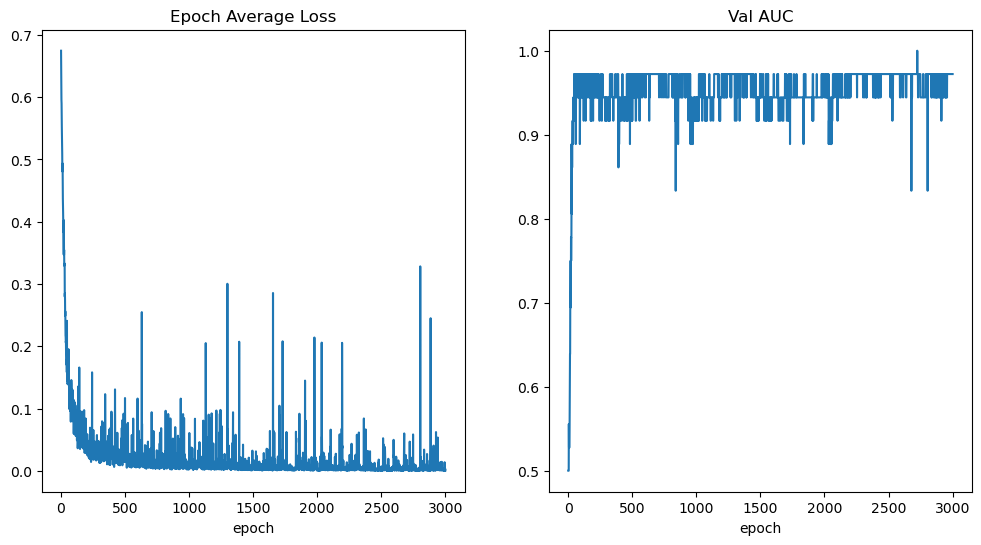

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Check best model output with the input image and label

In [37]:
model.load_state_dict(torch.load("best_metric_model_oc_densenet121.pth"))
model.eval()

val_ds = monai.data.Dataset(data=undersampled_test_files, transform=val_transforms)
val_loader = DataLoader(
    val_ds, 
    batch_size=1, 
    num_workers=0, 
    collate_fn=list_data_collate
)

list_imgs  = []
list_segs  = []
list_preds = []
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = (
                    val_data["img"].to(device),
                    val_data["seg"].to(device),
                )
        val_outputs = model(val_images)
        list_imgs.append(val_images)
        list_segs.append(val_labels)
        list_preds.append(val_outputs)
        
list_imgs = [np.squeeze(img.cpu().numpy()).transpose([1,2,0]) for img in list_imgs]
list_segs = [np.squeeze(seg.cpu().numpy()) for seg in list_segs]
list_preds_act = [(np.squeeze(sig_act(pred).cpu().numpy())).round() for pred in list_preds]

In [38]:
print(classification_report(list_segs, list_preds_act, digits=1))

              precision    recall  f1-score   support

         0.0        0.9       1.0       0.9        18
         1.0        1.0       0.9       0.9        18

    accuracy                            0.9        36
   macro avg        0.9       0.9       0.9        36
weighted avg        1.0       0.9       0.9        36



In [ ]:
#Show random 20 prediction
import random
#indexes = random.sample(range(1, 506), 20)
indexes = range(36)

soft_act = torch.nn.Softmax()
sig_act = torch.nn.Sigmoid()
for idx in indexes:
    img_cf  = list_imgs[idx]
    seg_cf  = list_segs[idx]
    pred = list_preds_act[idx]
    # channel last versions for plotting
    img = np.moveaxis(img_cf, [0,1,2], [-1,-3,-2])
    draw_image(img_cf)
    classification = 'open' if seg_cf == 1 else 'close'
    print('Image index: %d'%idx)
    print("ground truth\t", classification)
    print("prediction\t", 'open' if pred == 1 else 'close')
    

In [ ]:
#Show only close eyes to check their predictions
soft_act = torch.nn.Softmax()
sig_act = torch.nn.Sigmoid()

idx = 0 
while idx < len(list_imgs):
    pred = list_preds_act[idx]
    seg_cf  = list_segs[idx]
    if (seg_cf == 0):
        img_cf  = list_imgs[idx]
        pred = list_preds_act[idx]
        # channel last versions for plotting
        img = np.moveaxis(img_cf, [0,1,2], [-1,-3,-2])
        draw_image(img_cf)
        classification = 'open' if seg_cf == 1 else 'close'
        print('Image index: %d'%idx)
        print(classification)
        print(pred)
    idx += 1
